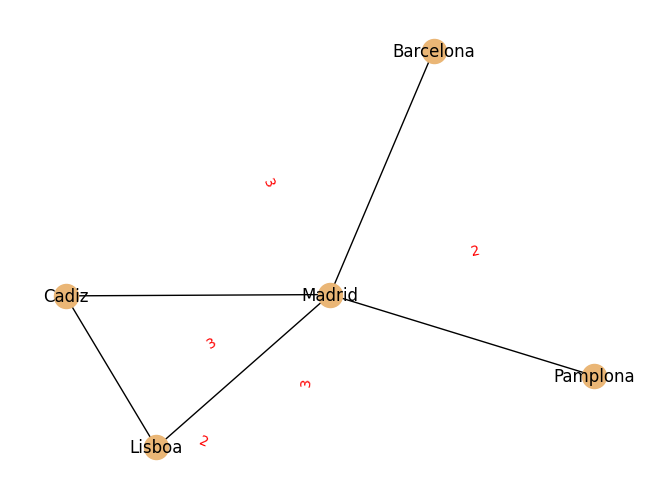

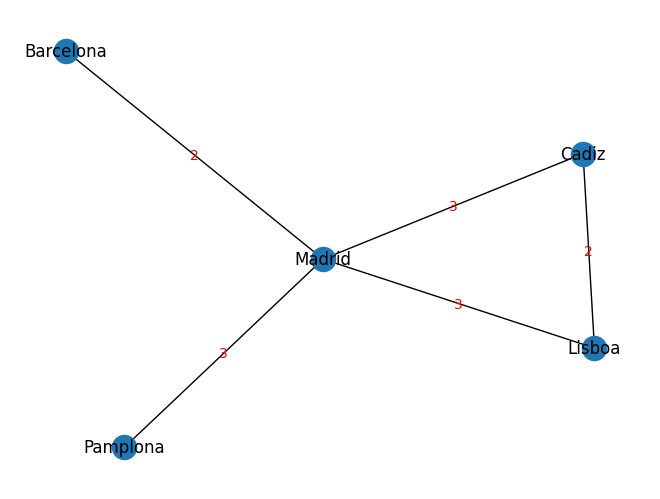

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

ONE = 1
TWO = 2
THREE = 3
FOUR = 4
FIVE = 5
SIX = 6
SEVEN = 7
EIGHT = 8

# Create a new graph
G = nx.Graph()

# Add nodes
G.add_node("Lisboa")
G.add_node("Cadiz")
G.add_node("Madrid")
G.add_node("Barcelona")
G.add_node("Pamplona")

# Add edges
G.add_edge("Lisboa", "Cadiz", weight=TWO)
G.add_edge("Madrid", "Lisboa", weight=THREE)
G.add_edge("Madrid", "Cadiz", weight=THREE)
G.add_edge("Madrid", "Pamplona", weight=THREE)
G.add_edge("Madrid", "Barcelona", weight=TWO)

#Show graph

pos = nx.spring_layout(G)

nx.draw(G, node_color="#eab676",with_labels=True)
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}


# Utilisez nx.draw_networkx_edge_labels pour ajouter les poids en tant qu'étiquettes sur les arêtes
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', label_pos=0.5)

plt.show()

pos = nx.spring_layout(G)

# Dessinez le graphe avec les noms des sommets
nx.draw(G, pos, with_labels=True)

# Créez un dictionnaire pour les étiquettes des arêtes
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}

# Ajustez manuellement les positions des étiquettes
label_pos = {edge: (pos[edge[0]][0] + (pos[edge[1]][0] - pos[edge[0]][0]) / 2, 
                    pos[edge[0]][1] + (pos[edge[1]][1] - pos[edge[0]][1]) / 2) 
             for edge in edge_labels}

# Utilisez nx.draw_networkx_labels pour ajouter les étiquettes des arêtes
nx.draw_networkx_labels(G, label_pos, edge_labels, font_color='red', font_size=10)

plt.show()


